# Random Forests and Behavioral Finance


This Notebook illustrates some of the work being done at the intersection of behavioral finance and machine learning.

The analysis in the notebook draws insperation from:

Machine Forecast Disagreement. Working Paper

"We propose a statistical model of heterogeneous beliefs where investors are represented as different machine learning model specifications.
Investors form return forecasts from their individual models using common data inputs.
We measure disagreement as forecast dispersion across investor-models (MFD).
Our measure aligns with analyst forecast disagreement but more powerfully predicts returns.
We document a large and robust association between belief disagreement and future returns.
A decile spread portfolio that sells stocks with high disagreement and buys stocks with low disagreement earns a value-weighted return of 14% per year.
Further analyses suggest MFD-alpha is mispricing induced by short-sale costs and limits-to-arbitrage."



---



In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt

# import additional packages

import ssl
ssl._create_default_https_context = ssl._create_stdlib_context


In [2]:
%matplotlib inline
warnings.filterwarnings('ignore')

### 1. $\quad$ Data

We'll use a function to download the FRED-MD dataset directly from the FRED website.

Alternatively, the data can be manually downloaded here:

https://www.stlouisfed.org/research/economists/mccracken/fred-databases

#### 1.1. $\quad$ Data download


In [3]:
# Retrieve the data
def load_data(fred_path: str):
    """
    Function to load data from FRED.

    Args:
    fred_path (str): URL to fetch the dataset from FRED.

    Returns:
    df: Loaded dataset
    tcodes: Transformation codes
    """

    print("Be patient: loading from FRED (2 minutes)")
    df = pd.read_csv(fred_path)[:-3]
    print("Done")

    tcodes = df.iloc[0, 1:]  # data tickers
    df.drop(0, inplace=True) # Drop unnecessary row

    # Set index to date and format it as datetime
    df = df.set_index("sasdate", drop=True)
    df.index = pd.to_datetime(df.index, format='%m/%d/%Y')

    return df, tcodes


In [4]:
# Define paths for the dataset
fred_path = 'https://www.stlouisfed.org/-/media/project/frbstl/stlouisfed/research/fred-md/monthly/2025-07-md.csv?sc_lang=en&hash=A1E7A098FEFE58C453870371DB34E6AF'

# Load the data
df, tcodes = load_data(fred_path)

df

Be patient: loading from FRED (2 minutes)
Done


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1959-01-01,2583.560,2426.0,15.188,2.766768e+05,17689.23968,21.9616,23.3868,22.2620,31.6664,18.9498,...,18.294,10.152,2.13,2.45,2.04,NaN,6476.00,12298.00,84.2043,NaN
1959-02-01,2593.596,2434.8,15.346,2.787140e+05,17819.01912,22.3917,23.7024,22.4549,31.8987,19.0492,...,18.302,10.167,2.14,2.46,2.05,NaN,6476.00,12298.00,83.5280,NaN
1959-03-01,2610.396,2452.7,15.491,2.777753e+05,17967.91336,22.7142,23.8459,22.5651,31.8987,19.4223,...,18.289,10.185,2.15,2.45,2.07,NaN,6508.00,12349.00,81.6405,NaN
1959-04-01,2627.446,2470.0,15.435,2.833627e+05,17978.97983,23.1981,24.1903,22.8957,32.4019,19.5466,...,18.300,10.221,2.16,2.47,2.08,NaN,6620.00,12484.00,81.8099,NaN
1959-05-01,2642.720,2486.4,15.622,2.853072e+05,18119.82573,23.5476,24.3911,23.1161,32.5567,19.9445,...,18.280,10.238,2.17,2.48,2.08,95.3,6753.00,12646.00,80.7315,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-01,20126.456,16412.1,122.396,1.545040e+06,712145.00000,101.9503,99.3545,98.8365,100.8370,102.2327,...,119.230,129.380,31.59,36.26,28.22,71.8,556011.41,938335.20,5381.7462,15.9822
2024-12-01,20148.534,16434.6,123.077,1.558008e+06,717662.00000,103.0447,100.4234,99.9346,101.6683,100.6563,...,119.746,129.875,31.72,36.43,28.33,74.0,559364.75,943484.76,5366.3388,15.6997
2025-01-01,20181.340,16430.3,122.386,1.542895e+06,711461.00000,102.8805,100.6125,100.1338,101.5923,98.5588,...,120.458,130.293,31.91,36.56,28.58,71.7,559708.93,944674.17,5351.9157,16.8122


#### 1.2. $\quad$ Data pre-processing



##### Transform the Data



In [5]:
def transxf(x, tcode):
    """
    DESCRIPTION:
    This function transforms a single series (in a column vector)
    as specified by a given transformation code.

    INPUT:
        x      : Series (in a column vector) to be transformed
        tcode  : Transformation code (1-7)

    OUTPUT:
        result : Transformed series (as a column vector)

    """
    # Number of observations (including missing values)
    n = x.size

    # Value close to zero
    small = 1e-6

    # Allocate output variables
    y = np.nan * np.ones(n)
    y1 = np.nan * np.ones(n)

    # Initialize result to ensure it's always defined
    result = np.nan * np.ones(n)

    # Transformation logic
    if tcode == 1:  # No transformation: x(t)
        result = x

    elif tcode == 2:  # First difference: x(t) - x(t-1)
        y[1:] = x[1:] - x[:-1]
        result = y

    elif tcode == 3:  # Second difference: (x(t) - x(t-1)) - (x(t-1) - x(t-2))
        y[2:] = x[2:] - 2 * x[1:-1] + x[:-2]
        result = y

    elif tcode == 4:  # Natural log: ln(x)
        if np.min(x) < small:
            result = np.nan
        else:
            result = np.log(x)

    elif tcode == 5:  # First difference of natural log: ln(x) - ln(x-1)
        if np.min(x[pd.notnull(x)]) > small:
            log_x = np.log(x)
            y[1:] = log_x[1:] - log_x[:-1]
            result = y

    elif tcode == 6:  # Second difference of natural log
        if np.min(x[pd.notnull(x)]) > small:
            log_x = np.log(x)
            y[2:] = log_x[2:] - 2 * log_x[1:-1] + log_x[:-2]
            result = y

    elif tcode == 7:  # First difference of percent change
        y1[1:] = (x[1:] - x[:-1]) / x[:-1]
        y[2:] = y1[2:] - y1[1:-1]
        result = y

    return result


In [6]:
yt = []             # Initialize output variable
N = df.shape[1]     # Number of series kept

for i in range(N):
    dum = transxf(df.iloc[:, i].values, tcodes[i])
    yt.append(dum)

transformed_data = pd.DataFrame(yt).T
transformed_data.columns = df.columns
transformed_data.index = df.index

# transformed_data.dropna(axis=0, how='any', inplace=True)

transformed_data.head()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1959-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-02-01,0.003877,0.003621,0.010349,0.007336,0.007310,0.019395,0.013405,0.008628,0.007309,0.005232,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-03-01,0.006457,0.007325,0.009404,-0.003374,0.008321,0.014300,0.006036,0.004896,0.000000,0.019397,...,-0.001148,0.000292,-0.000022,-0.008147,0.004819,NaN,0.004929,0.004138,-0.014792,NaN
1959-04-01,0.006510,0.007029,-0.003622,0.019915,0.000616,0.021080,0.014339,0.014545,0.015652,0.006379,...,0.001312,0.001760,-0.000022,0.012203,-0.004890,NaN,0.012134,0.006734,0.024929,NaN
1959-05-01,0.005796,0.006618,0.012043,0.006839,0.007803,0.014954,0.008267,0.009580,0.004766,0.020152,...,-0.001695,-0.001867,-0.000021,-0.004090,-0.004819,NaN,0.002828,0.002020,-0.015342,NaN


### 2. $\quad$ Defining the Model

1. Define the target
2. Define the feature set
3. Define a expanding / rolling window forecasting scheme
4. Select and train the model (hyperparameters)
5. Predict OOS


In [7]:
transformed_data.ffill(limit=3,inplace=True)

transformed_data['target'] = transformed_data['S&P 500'].shift(-1)
transformed_data.dropna(axis=0, how='any', inplace=True)
y = transformed_data['target']

x = transformed_data.drop('target', axis=1)

In [8]:
y

sasdate
1992-03-01    0.000123
1992-04-01    0.018001
1992-05-01   -0.015892
1992-06-01    0.016470
1992-07-01    0.006915
                ...   
2024-10-01    0.023478
2024-11-01    0.013565
2024-12-01   -0.005236
2025-01-01    0.009847
2025-02-01   -0.060535
Name: target, Length: 396, dtype: float64

In [18]:
import random

from joblib import Parallel, delayed
from sklearn.ensemble import RandomForestRegressor


def fit_predict_once(i, X_train, y_train, X_test, subset):
    # reproducible, per-investor feature subsample
    rng = random.Random(i)
    p = max(1, int(X_train.shape[1] * subset))
    feat_idx = rng.sample(range(X_train.shape[1]), p)

    model = RandomForestRegressor(
        n_estimators=2000,
        max_depth=3,
        max_features=0.05,
        max_samples=0.05,
        n_jobs=1,              # ← outer parallelism via joblib; keep RF single-threaded
        random_state=i,
    )
    model.fit(X_train.iloc[:, feat_idx], y_train)
    return model.predict(X_test.iloc[:, feat_idx])[0]

investors = 100
subset = 0.5

training_set_size = 120
y_hat, y_true = [], []
uncertainty = []

for t in range(training_set_size, len(x)):
    X_train = x.iloc[t-training_set_size:t]
    y_train = y.iloc[t-training_set_size:t]

    X_test = x.iloc[t:t+1]
    y_test = y.iloc[t]

    # Run in parallel across investors
    # set n_jobs to your desired parallel workers (e.g., -1 for all cores)
    y_pred = Parallel(n_jobs=10, backend="loky", verbose=0)(
        delayed(fit_predict_once)(i, X_train, y_train, X_test, subset)
        for i in range(investors)
    )

    """
    y_pred = []

    for i in range(investors):

        feature_indices = random.sample(range(X_train.shape[1]), int(X_train.shape[1]*subset))

        model = RandomForestRegressor(
            n_estimators=2000,
            max_depth=3,
            max_features=0.05,
            max_samples=0.05,
            n_jobs=10,
            random_state=i,
        )
        model.fit(X_train.iloc[:, feature_indices], y_train)

        y_pred_i = model.predict(X_test.iloc[:, feature_indices])[0]
        y_pred.append(y_pred_i)
    """

    y_hat.append(np.mean(y_pred))
    y_true.append(y_test)

    uncertainty.append(np.std(y_pred))

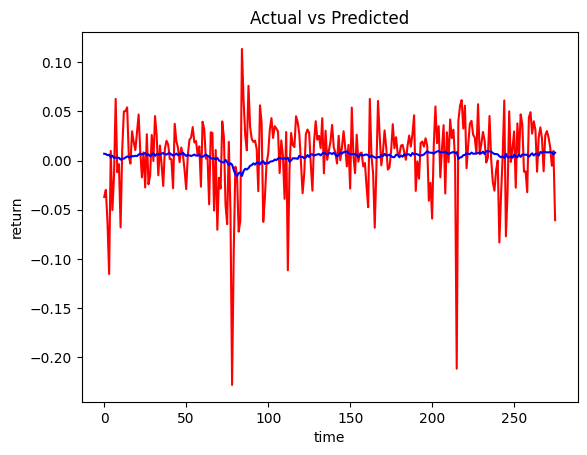

In [31]:
plt.figure()
plt.plot(y_true, color='red')
plt.plot(y_hat, color='blue')
plt.title('Actual vs Predicted')
plt.xlabel('time')
plt.ylabel('return')

plt.show()

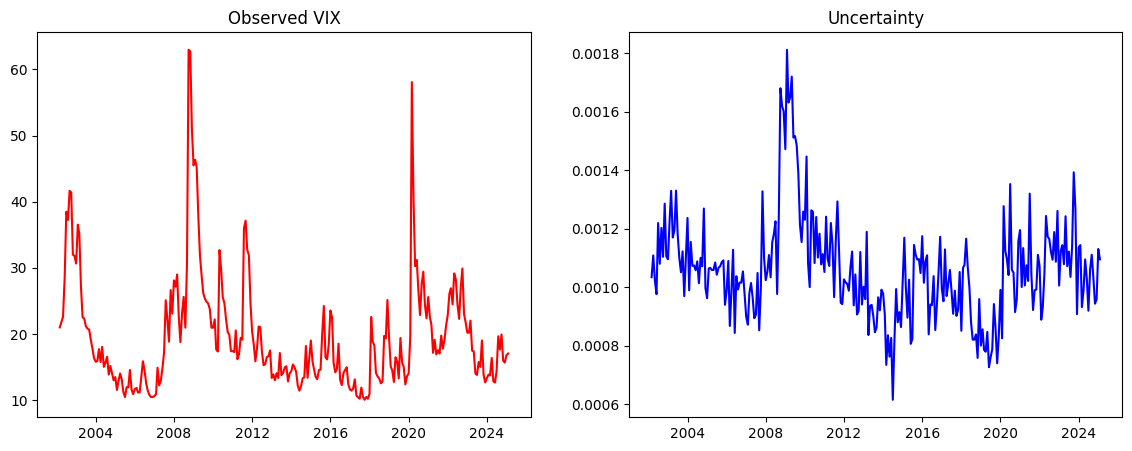

In [30]:
# Perform out of sample prediction
plt.figure(figsize = (14,5))

#Predicted RV
plt.subplot(1,2,1)
plt.plot(transformed_data['VIXCLSx'][120:].index, transformed_data['VIXCLSx'][120:], color='red')
plt.title("Observed VIX")

#Actual RV
plt.subplot(1,2,2)
plt.plot(transformed_data['VIXCLSx'][120:].index, uncertainty, color = "blue")
plt.title("Uncertainty")
plt.show()

In [29]:
print(f"Correlation between Machine Forecast Disagreement and VIX: {np.corrcoef(transformed_data['VIXCLSx'][120:], uncertainty)[0][1]:.4f}")

print(f"R2 measure, {np.corrcoef(transformed_data['VIXCLSx'][120:], uncertainty)[0][1]**2:.4f}")

Correlation between Machine Forecast Disagreement and VIX: 0.6294
R2 measure, 0.3962


In [22]:
# Metrics
def score(y_hat, y, metric):
    """Return metrics of y_hat vs. y

    Args:
        y_hat (np.array): Predicted values
        y (np.array): Actual values
        metric (str): Metric to use

    Returns:
        float: The metric
    """
    if metric == "MSE":
        return np.mean( (y_hat-y)**2)
    elif metric == "R_squared":
        ss_res = np.sum( (y - y_hat)**2 )
        ss_tot = np.sum( (y - np.average(y)) **2)
        return 1 - ss_res/ss_tot
    elif metric == "MAE":
        return np.mean( np.abs(y-y_hat))

In [23]:
#Out-of-sample scores
print("Out-of-sample scores")

y_hat = np.array(y_hat)
y_true = np.array(y_true)

mse_oos = score(y_hat, y_true, "MSE")
r_sq_oos = score(y_hat, y_true, "R_squared")
mae_oos = score(y_hat, y_true, "MAE")

print(f"MSE:{mse_oos}, R^2:{r_sq_oos}, MAE:{mae_oos}")

Out-of-sample scores
MSE:0.0014239961382817804, R^2:-0.004181420130922708, MAE:0.026519322561891354
